# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [ ]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
from numpy import random

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg', 'pdf']
import os
from PIL import Image, ImageEnhance

from copy import copy

#%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')

from tqdm.notebook import tqdm

In [ ]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        # your code here
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.transforms = transforms
        #self.images = []
        #self.masks = []
        self.names = os.listdir(images_dir)
        
        
    def __len__(self):
        return len(self.names)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        cur_im = Image.open(self.images_dir + self.names[idx])
        cur_mask = None
        if self.target_dir is not None:
            cur_mask = Image.open(self.target_dir + self.names[idx][:-3] + 'png')
            if self.transforms is not None:
                for t in self.transforms[:-2]:
                    new_im = t(cur_im, cur_mask)
                    if new_im is not None:
                        cur_mask = new_im[1]
                        cur_im = new_im[0]
                cur_im = self.transforms[-2](cur_im)
                cur_im = self.transforms[-1](cur_im)
                cur_mask = self.transforms[-2](cur_mask) 
        return (cur_im, cur_mask)

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [ ]:
# your code here
class RandomHorizontalFlip(object):
    def __init__(self, mode=0.5):
        self.method = mode

    def __call__(self, img, mask):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        p = random.random()
        if self.method >= p:
            new_img = img.transpose(Image.FLIP_LEFT_RIGHT)
            new_mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
            return (new_img, new_mask)
        return None


In [ ]:
class RandomCrop(object):
    def __init__(self, mode=0.5, h=None, w=None):
        self.method = mode
        self.h = h
        self.w = w

    def __call__(self, img, mask):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.h is None:
            self.h = random.random() * img.size[1]
        if self.w is None:
            self.w = random.random() * img.size[0]
        area = self.h * self.w
        p = random.random()
        if self.method >= p and area > 10000:
            y = random.random() * (img.size[1] - self.h)
            x = random.random() * (img.size[0] - self.w)
            new_img = img.crop((x, y, x + self.w, y + self.h))
            new_img = new_img.resize((img.size[0], img.size[1]))
            new_mask = mask.crop((x, y, x + self.w, y + self.h))
            new_mask = new_mask.resize((img.size[0], img.size[1]))
            return (new_img, new_mask)
        return None

In [ ]:
class ColorBrightness(object):
    def __init__(self, mode=0.5, factor=None):
        self.method = mode
        self.factor = None
        if factor is None:
            self.factor = random.random()
    def __call__(self, img, mask):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        p = random.random()
        if self.method >= p:
            enhancer = ImageEnhance.Brightness(img)
            new_img = enhancer.enhance(self.factor)
            return (new_img, mask)
        return None

In [ ]:
class RandomBackground(object):
    def __init__(self, path, mode=0.5):
        self.method = mode
        self.image_list = []
        names = os.listdir(path)
        for imagename in names:
            im = Image.open(path + imagename)
            self.image_list.append(im)

    def __call__(self, img, mask):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        p = random.random()
        if self.method >= p:
            num = random.randint(low=0, high = len(self.image_list))
            new_img = Image.composite(img, self.image_list[num], mask)
            return (new_img, mask)
        return None

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [ ]:
DATA_PATH = 'people_data/'# your path

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=[RandomHorizontalFlip(), RandomCrop(), ColorBrightness(), 
                RandomBackground(path=DATA_PATH + 'train/'), transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=[transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)

Функция для отображения изображения:

In [ ]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

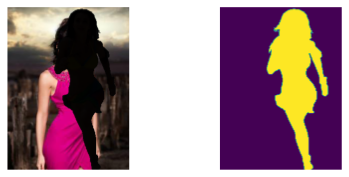

In [ ]:
# your code here
show_idx_image(train_dataset, 0)

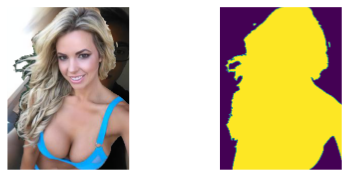

In [ ]:
show_idx_image(train_dataset, 1)

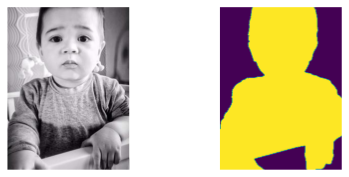

In [ ]:
show_idx_image(train_dataset, 2)

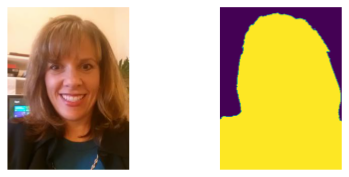

In [ ]:
show_idx_image(train_dataset, 3)

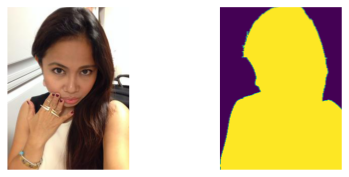

In [ ]:
show_idx_image(train_dataset, 4)

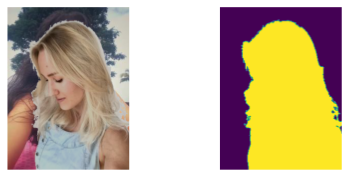

In [ ]:
show_idx_image(train_dataset, 5)

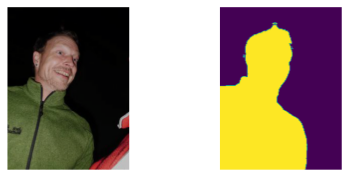

In [ ]:
show_idx_image(train_dataset, 6)

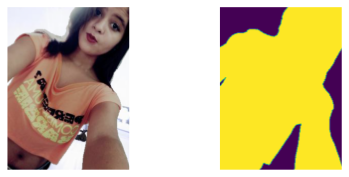

In [ ]:
show_idx_image(train_dataset, 7)

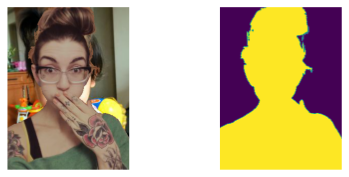

In [ ]:
show_idx_image(train_dataset, 23)

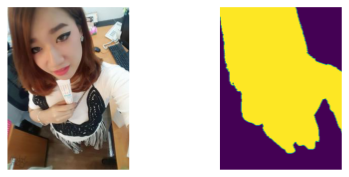

In [ ]:
show_idx_image(train_dataset, 39)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dice = 2 * torch.sum(logits * true_labels, (1, 2)) / torch.sum(logits + true_labels + self.eps, (1, 2))
        dice = 1 - dice
        
        if self.reduction == 'sum':
            loss_value = torch.sum(dice)
        elif self.reduction == 'mean':
            loss_value = torch.mean(dice)
        elif self.reduction is None:
            loss_value = dice
            
        return loss_value

Проверка реализации:

In [ ]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [ ]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [ ]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [ ]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach()) * labels.size(0)
            correct += float(val_criterion(outputs, labels).detach()) * labels.size(0)
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

In [ ]:
def IOU(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    return torch.sum(y_pred * y_true) / torch.sum(y_pred + y_true - y_pred * y_true)

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [ ]:
num_epoch = 15
lr = 1e-4
weight_decay = 1e-4
step_size = 50
gamma = 0.5

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
# your code here
def train(model):
    loss_list = []
    acc_list = []
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in train_data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        mean_loss, metric = evaluate_net(model, test_data_loader, criterion, val_criterion, device)
        print('Epoch :', epoch, 'mean_loss :', mean_loss, 'acc :', metric)
        loss_list.append(mean_loss)
        acc_list.append(metric)
    torch.save(model.state_dict(), 'path_to_model.pth')
    return loss_list, acc_list

In [ ]:
loss, acc = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.18256662310437954 acc : 0.8326594706968213
Epoch : 1 mean_loss : 0.19465688653026067 acc : 0.8143334173141642
Epoch : 2 mean_loss : 0.1478286493331828 acc : 0.8776064067022175
Epoch : 3 mean_loss : 0.22852230537022258 acc : 0.8220932779582679
Epoch : 4 mean_loss : 0.1671888305151716 acc : 0.8780538913206006
Epoch : 5 mean_loss : 0.24096025642773783 acc : 0.8493626392479484
Epoch : 6 mean_loss : 0.1659110888098994 acc : 0.8596123444273117
Epoch : 7 mean_loss : 0.141739584716922 acc : 0.8930489086935706
Epoch : 8 mean_loss : 0.1701497807041973 acc : 0.8509363946339763
Epoch : 9 mean_loss : 0.18170543950288853 acc : 0.8607663943412456
Epoch : 10 mean_loss : 0.14410503689490312 acc : 0.878071940959768
Epoch : 11 mean_loss : 0.1527579664549929 acc : 0.8566111689763711
Epoch : 12 mean_loss : 0.14077369620402655 acc : 0.8593360409668996
Epoch : 13 mean_loss : 0.1422408476788947 acc : 0.873084601358319
Epoch : 14 mean_loss : 0.17926105634963257 acc : 0.8536057763911308


No handles with labels found to put in legend.
No handles with labels found to put in legend.


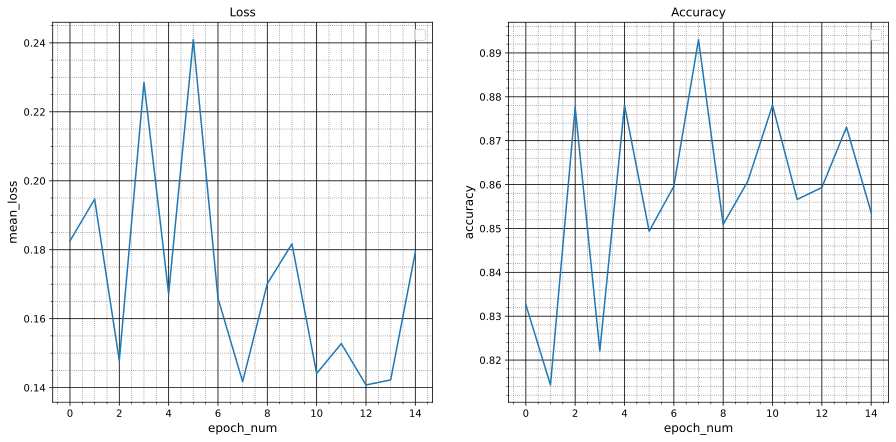

In [ ]:
fig = plt.figure(figsize=(15,7))
#plt.title('Кросс-энтропия')

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('mean_loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), loss)
plt.legend(fontsize = 14)
plt.title("Loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), acc)
plt.legend(fontsize = 14)
plt.title("Accuracy")

plt.show()

In [ ]:

model.load_state_dict(torch.load('path_to_model_BCE.pth'))

<All keys matched successfully>

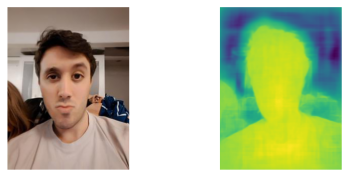

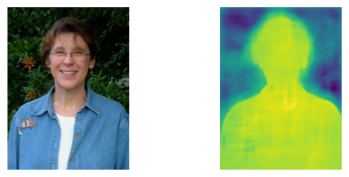

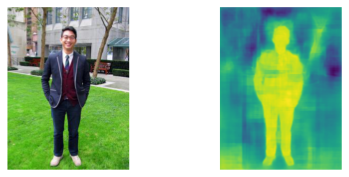

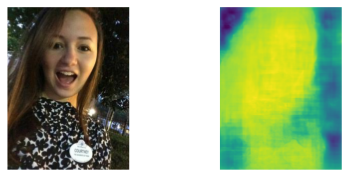

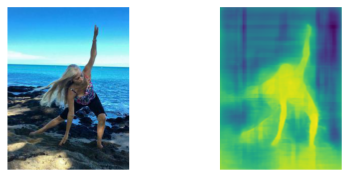

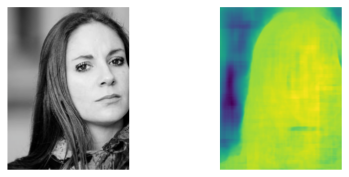

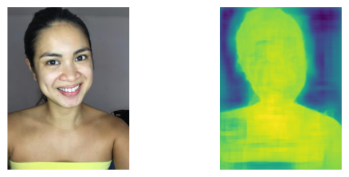

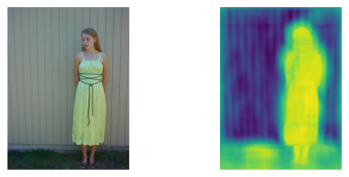

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** 15 эпох оказалось маловато для сходимости, но на графике метрики можно заметить, что ближе к 14 эпохе разброс начал уменьшаться. Качество оказалось приемлемым, что подтверждают выведенные выше предсказанные маски. На них видны общие силуэты (довольно точно), но отсутствуют детали.

In [ ]:
criterion = DiceLoss(reduction='mean')
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
dice_loss, dice_acc = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.3031523934704192 acc : 0.6039797625643142
Epoch : 1 mean_loss : 0.3031523934704192 acc : 0.6039797625643142
Epoch : 2 mean_loss : 0.3031523900885954 acc : 0.6039797625643142
Epoch : 3 mean_loss : 0.3031523221350731 acc : 0.6039802055832342
Epoch : 4 mean_loss : 0.30315211890859806 acc : 0.6039854144373684
Epoch : 5 mean_loss : 0.3022320149004037 acc : 0.605286291305055
Epoch : 6 mean_loss : 0.3022266009175186 acc : 0.6053029894828796
Epoch : 7 mean_loss : 0.30314020981602635 acc : 0.604003462808352
Epoch : 8 mean_loss : 0.29037667208529533 acc : 0.6541320783026675
Epoch : 9 mean_loss : 0.2500057556527726 acc : 0.6954368703754236
Epoch : 10 mean_loss : 0.24731139648467937 acc : 0.7117052154338106
Epoch : 11 mean_loss : 0.2182289202373924 acc : 0.750445102123504
Epoch : 12 mean_loss : 0.2001488149588835 acc : 0.7763525454710561
Epoch : 13 mean_loss : 0.19669021158776384 acc : 0.788398341929659
Epoch : 14 mean_loss : 0.18902284741824402 acc : 0.8035995068279564


No handles with labels found to put in legend.
No handles with labels found to put in legend.


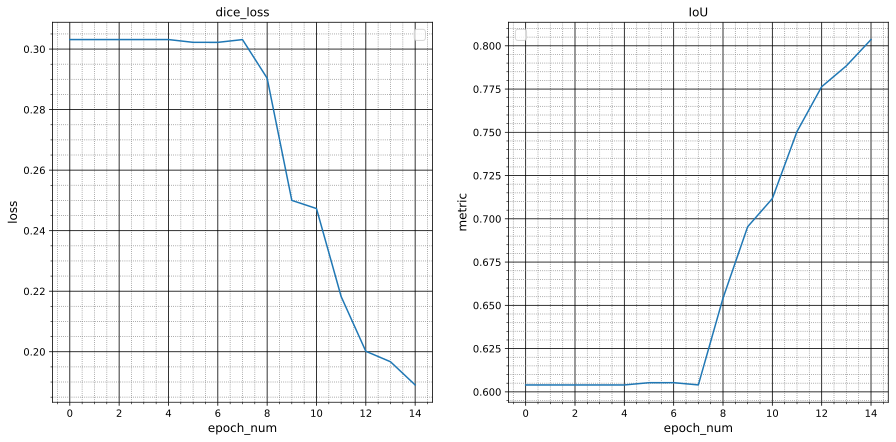

In [ ]:
fig = plt.figure(figsize=(15,7))
#plt.title('Кросс-энтропия')

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), dice_loss)
plt.legend(fontsize = 14)
plt.title("dice_loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('metric', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), dice_acc)
plt.legend(fontsize = 14)
plt.title("IoU")

plt.show()

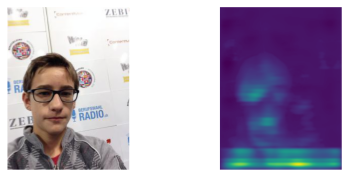

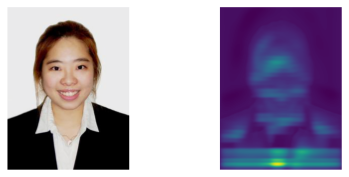

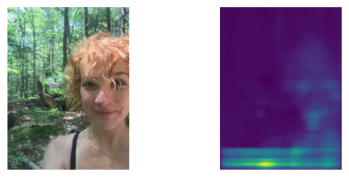

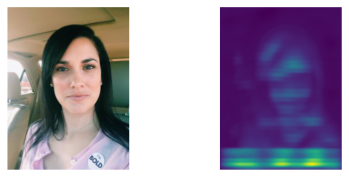

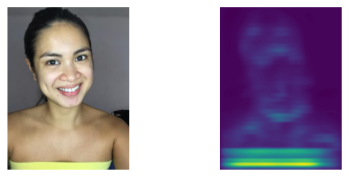

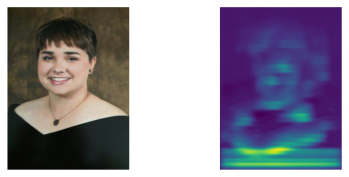

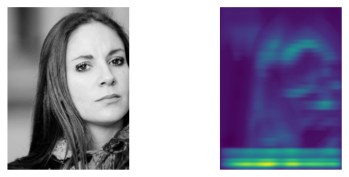

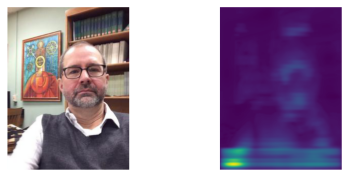

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** нейросеть обучилась не очень хорошо, 15 эпох также оказалось недостаточно, потому что не произошло выхода на плато. Качество оказывается хуже, чем при использовании BCE. На маскахс трудом можно различить силуэты, больше внимания уделено мелким деталям.

In [ ]:
class DiceBCE(nn.Module):
    def __init__(self, eps=1e-7, reduction='mean', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        self.DiceLoss = DiceLoss(eps=eps, reduction=reduction, 
                               with_logits=with_logits)
        self.BCE = nn.BCEWithLogitsLoss()
        
    def forward(self, logits, true_labels):
        loss_value = (self.DiceLoss.forward(logits, true_labels) + self.BCE.forward(logits, true_labels)) / 2    
        return loss_value

In [ ]:
criterion = DiceBCE(reduction='mean')
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
sum_loss, sum_acc = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.2540456300720255 acc : 0.7260389780321865
Epoch : 1 mean_loss : 0.1866708518342769 acc : 0.831256424704342
Epoch : 2 mean_loss : 0.1672450418167926 acc : 0.8677816965901259
Epoch : 3 mean_loss : 0.1839025615588993 acc : 0.827596627651377
Epoch : 4 mean_loss : 0.16317841854501278 acc : 0.8709872504498096
Epoch : 5 mean_loss : 0.1651562841226023 acc : 0.859583981916414
Epoch : 6 mean_loss : 0.16814965686054095 acc : 0.8402878460309184
Epoch : 7 mean_loss : 0.1532312701357172 acc : 0.8732282608113391
Epoch : 8 mean_loss : 0.15737964915679703 acc : 0.8601423146876883
Epoch : 9 mean_loss : 0.20071716574912377 acc : 0.8380777861209626
Epoch : 10 mean_loss : 0.15640093808901226 acc : 0.8562497686832509
Epoch : 11 mean_loss : 0.15656253959692962 acc : 0.865737592074888
Epoch : 12 mean_loss : 0.14969334867617762 acc : 0.8704851798131956
Epoch : 13 mean_loss : 0.15224537528153007 acc : 0.8683874218176443
Epoch : 14 mean_loss : 0.16679576197837262 acc : 0.8465947677903142


No handles with labels found to put in legend.
No handles with labels found to put in legend.


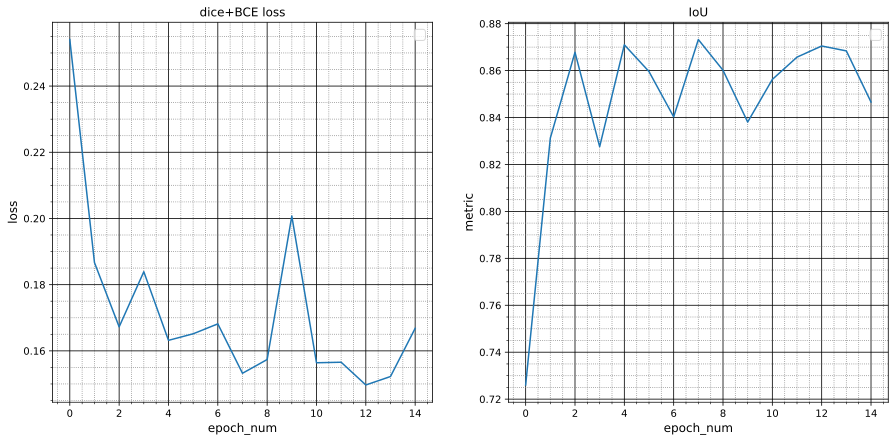

In [ ]:
fig = plt.figure(figsize=(15,7))
#plt.title('Кросс-энтропия')

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), sum_loss)
plt.legend(fontsize = 14)
plt.title("dice+BCE loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('metric', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), sum_acc)
plt.legend(fontsize = 14)
plt.title("IoU")

plt.show()

In [ ]:
model.load_state_dict(torch.load('path_to_model_sum.pth'))

<All keys matched successfully>

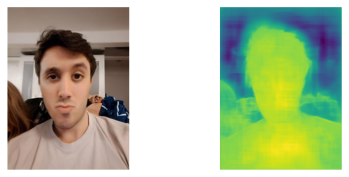

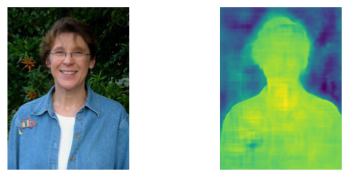

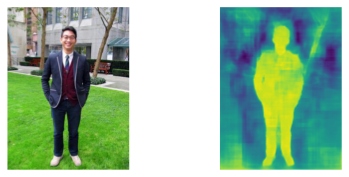

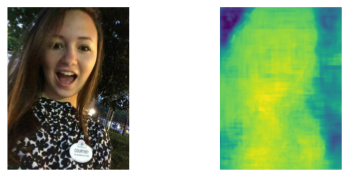

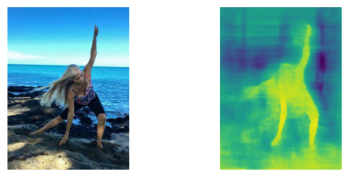

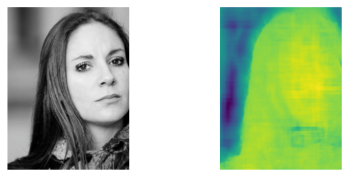

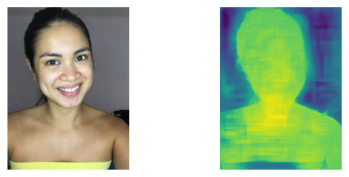

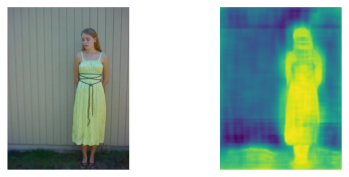

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** при использовании взвешенной суммы функций потерь результат получился довольно хороший, качество распознавания не низкое. На масках отчетливо видны силуэты, но в то же время проглядываются и детали.

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [ ]:
# your code here
class LinkDecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(x + left))
        x = self.relu(self.conv2(x))
        return x

In [ ]:
class LinkDecoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', LinkDecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [ ]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = LinkDecoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LinkNet()
model = model.to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
link_BCE_loss, link_BCE_metric = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.3142336167342274 acc : 0.7185975486505116
Epoch : 1 mean_loss : 0.430814043849918 acc : 0.5796545959533529
Epoch : 2 mean_loss : 0.25624386110204334 acc : 0.7322749491279007
Epoch : 3 mean_loss : 0.2383133534421312 acc : 0.7554339686184065
Epoch : 4 mean_loss : 0.28544351162639914 acc : 0.6988040293362123
Epoch : 5 mean_loss : 0.3456800273546936 acc : 0.6609203346232151
Epoch : 6 mean_loss : 0.21939207528922575 acc : 0.7650255886375481
Epoch : 7 mean_loss : 0.2132174793287372 acc : 0.7954586380762412
Epoch : 8 mean_loss : 0.2572180036957382 acc : 0.7136329391323928
Epoch : 9 mean_loss : 0.22122286936492785 acc : 0.7763944665590922
Epoch : 10 mean_loss : 0.2684856452417712 acc : 0.7273348214778494
Epoch : 11 mean_loss : 0.30015227790419935 acc : 0.6999994985600735
Epoch : 12 mean_loss : 0.21526115805122023 acc : 0.7853473103638237
Epoch : 13 mean_loss : 0.21516200741554828 acc : 0.7979787008982178
Epoch : 14 mean_loss : 0.21593594160063048 acc : 0.784828746572453

No handles with labels found to put in legend.
No handles with labels found to put in legend.


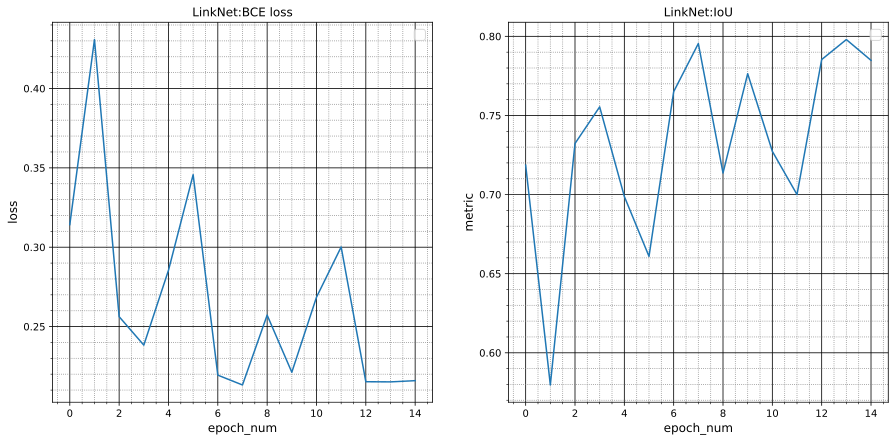

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_BCE_loss)
plt.legend(fontsize = 14)
plt.title("LinkNet:BCE loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('metric', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_BCE_metric)
plt.legend(fontsize = 14)
plt.title("LinkNet:IoU")

plt.show()

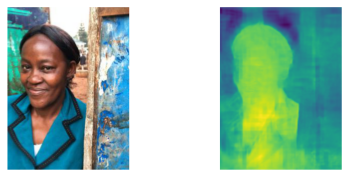

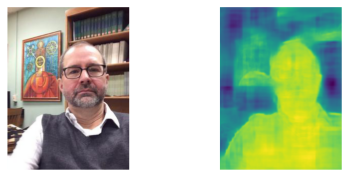

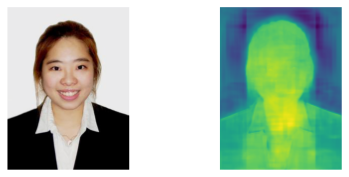

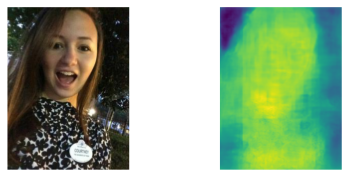

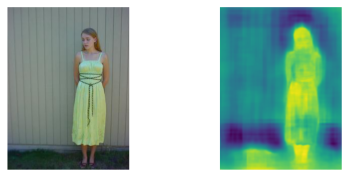

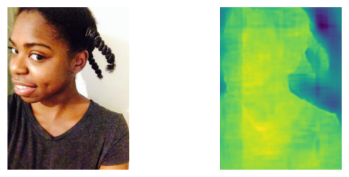

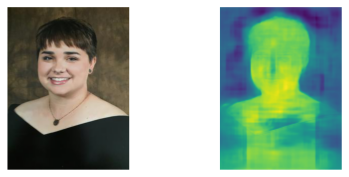

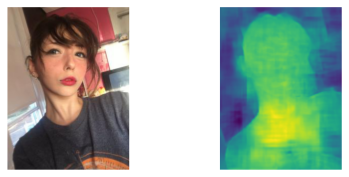

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** по графикам видно, что сеть обучилась не очень хорошо, качество нельзя назвать высоким. Маски это подтверждают: какие-то изображения распознались хорошо, виедн силуэт и некоторые детали, а где-то даже силуэт оказывается очень размытым. Если сравнивать с Unet, то окажется, что качество при таких же параметрах у LinkNet оказалось хуже. Время обучения немного сократилось, но на очень незначительную величину.

In [ ]:
criterion = DiceLoss(reduction='mean')
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
link_Dice_loss, link_Dice_metric = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.30315239822610895 acc : 0.6039797524188427
Epoch : 1 mean_loss : 0.30315239822610895 acc : 0.6039797524188427
Epoch : 2 mean_loss : 0.30315233545100434 acc : 0.6039799071372823
Epoch : 3 mean_loss : 0.3031506692686825 acc : 0.6039846632497531
Epoch : 4 mean_loss : 0.3031404977994608 acc : 0.6040028266027464
Epoch : 5 mean_loss : 0.23789734578301722 acc : 0.7099817158482599
Epoch : 6 mean_loss : 0.22494121371431552 acc : 0.7545244410528359
Epoch : 7 mean_loss : 0.18607591314518707 acc : 0.8087102487577614
Epoch : 8 mean_loss : 0.18343151112397513 acc : 0.8091661207219387
Epoch : 9 mean_loss : 0.1757051998630483 acc : 0.8303191082697388
Epoch : 10 mean_loss : 0.16146124973364756 acc : 0.847993939480883
Epoch : 11 mean_loss : 0.1622665228573143 acc : 0.8470363329488335
Epoch : 12 mean_loss : 0.1598132534864101 acc : 0.8416297651351766
Epoch : 13 mean_loss : 0.15671270853238747 acc : 0.8519709507624308
Epoch : 14 mean_loss : 0.15497408648754687 acc : 0.8577838514713

No handles with labels found to put in legend.
No handles with labels found to put in legend.


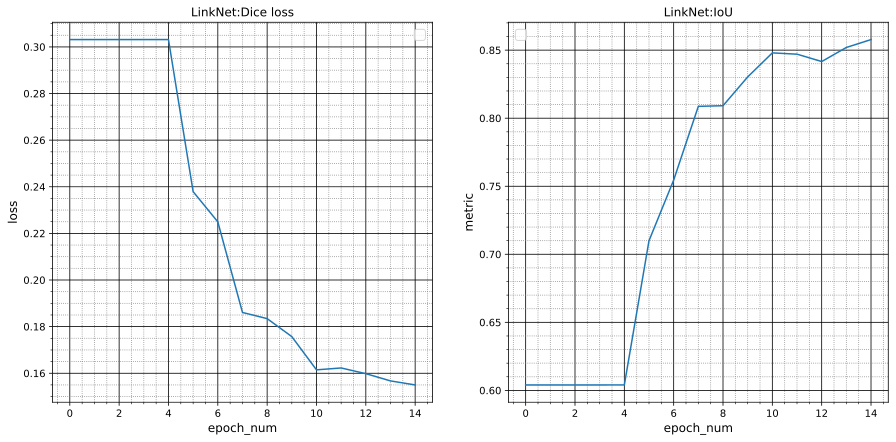

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_Dice_loss)
plt.legend(fontsize = 14)
plt.title("LinkNet:Dice loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('metric', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_Dice_metric)
plt.legend(fontsize = 14)
plt.title("LinkNet:IoU")

plt.show()

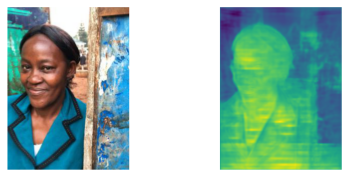

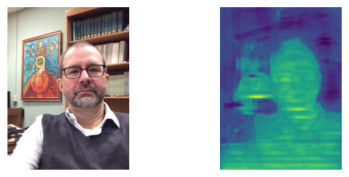

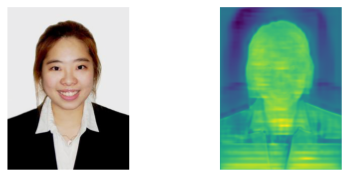

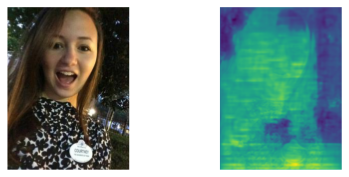

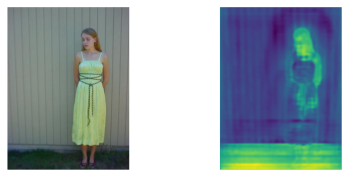

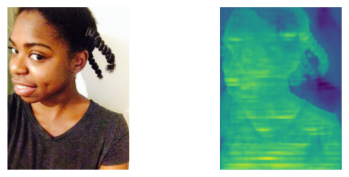

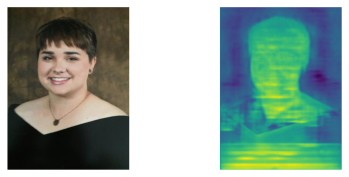

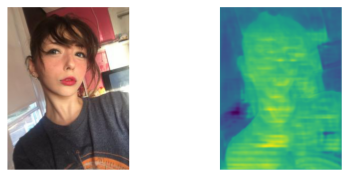

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** нейросеть показывает неплохое качество, но все же иногда силуэты трудно различимы. Маски "загрязнены" желтыми полосами, но все же, если сравнивать с Unet, окажется, что здесь результаты лучше: это видно как на графике, так и на масках, выведенных выше. Время обучения незначительно, но уменьшилось.

In [ ]:
criterion = DiceBCE(reduction='mean')
val_criterion = IOU
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


In [ ]:
link_sum_loss, link_sum_metric = train(model)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch : 0 mean_loss : 0.2336824557459946 acc : 0.7646218217011039
Epoch : 1 mean_loss : 0.2042115104536638 acc : 0.8093899847767877
Epoch : 2 mean_loss : 0.16906595673966915 acc : 0.8553298191821321
Epoch : 3 mean_loss : 0.18685936769272418 acc : 0.8142513827229223
Epoch : 4 mean_loss : 0.1783337375373705 acc : 0.8437127331469921
Epoch : 5 mean_loss : 0.21950618024413468 acc : 0.8090756514393691
Epoch : 6 mean_loss : 0.17119313279787698 acc : 0.8337554623049201
Epoch : 7 mean_loss : 0.1504715395734665 acc : 0.8814480300490738
Epoch : 8 mean_loss : 0.16898197728268644 acc : 0.8516133368438017
Epoch : 9 mean_loss : 0.16444080095764593 acc : 0.8632769250700659
Epoch : 10 mean_loss : 0.21298340089777681 acc : 0.8317393977591332
Epoch : 11 mean_loss : 0.15423406882488983 acc : 0.8681588718231689
Epoch : 12 mean_loss : 0.14863460854435642 acc : 0.8769510113601143
Epoch : 13 mean_loss : 0.1583909527629825 acc : 0.8885822608961281
Epoch : 14 mean_loss : 0.16888964038791385 acc : 0.861672196827

No handles with labels found to put in legend.
No handles with labels found to put in legend.


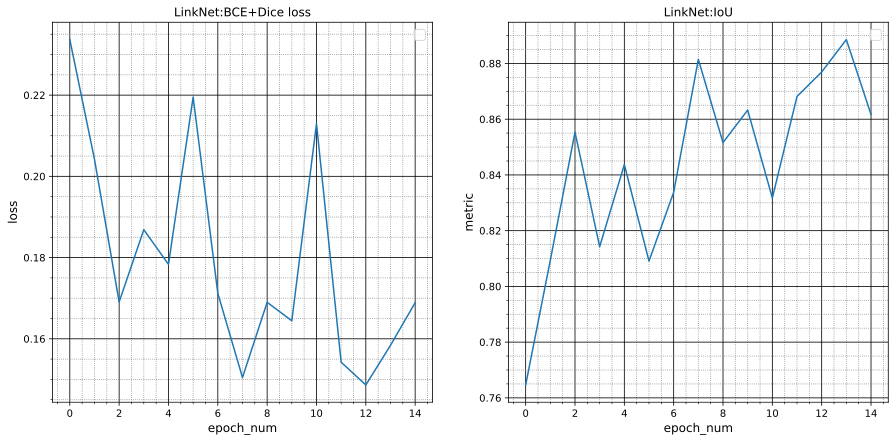

In [ ]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(121)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_sum_loss)
plt.legend(fontsize = 14)
plt.title("LinkNet:BCE+Dice loss")

ax2 = fig.add_subplot(122)
plt.xlabel('epoch_num', fontsize=12)
plt.ylabel('metric', fontsize=12)
plt.grid(True)
plt.grid(which='major', color = 'k')
plt.minorticks_on()
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.plot(np.arange(15), link_sum_metric)
plt.legend(fontsize = 14)
plt.title("LinkNet:IoU")

plt.show()

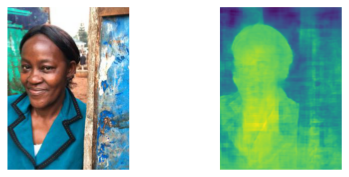

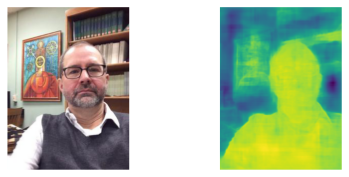

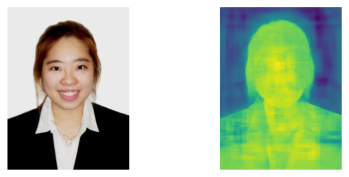

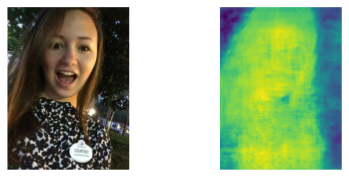

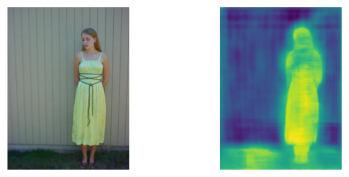

In [ ]:
with torch.no_grad():
  img, label = next(iter(test_data_loader))
  img = img.to(device)
  label = label.to(device)
  pred = model(img)
  img = img.to('cpu')
  pred = pred.to('cpu')
  for i in range(8):
      image_to_show = (img[i], pred[i])[0].transpose(0, 1).transpose(1, 2).numpy()
      image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
      image_to_show = np.clip(image_to_show, 0, 1)
      mask_to_show = (img[i], pred[i])[1][0].numpy()
      fig, ax = plt.subplots(1, 3)
      fig.set_figwidth(7)
      fig.set_figheight(3)


      plt.subplot(1, 2, 1)
      plt.imshow(image_to_show)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.imshow(mask_to_show)
      plt.axis('off')

**Вывод:** качество получилось очень неплохое, но 15 эпох снова оказалось недостаточно для сходимости - на графиках видны сильные скачки. Предсказанные маски соответствуют изображениям, причем на них как видны силуэты, так и проступают некоторые детали. Но время обучения существенно выше, чем у Unet при таких же параметрах.

**Вывод:** LinkNet позволяет выиграть по времени, а Unet - по качеству (за исключением случая функции потерь dice, но с ней в обеих сетях все плохо), но не стоит ограничиваться 15 эпохами, потому что их почти нигде не достаточно для сходимости.

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

1. Локальная зависимость входных данных: в случае изображения каждый пиксель зависит от пикселей, расположенных в некоторой окрестности. Поэтому не нужно искать зависимости между расположенными далеко друг от друга пикселями, и нейросеть обучается быстрее, сокращается число вычислений.
2. Некоторые фрагменты входных данных (картинок) повторяются, сверточная нейросеть позволяет обнаружить такие паттерны, вследствие чего становится устойчивой к поворотам и сдвигам изображения.\
Пример: подается перемешанное изображение из игры пятнашки, будет очень сложно определить, что оно из себя представляет, особенно если число кусочков велико.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

1. f: 1000 $\times$ 1, g: 100 $\times$ 10
2. f: 1000 $\times$ 100 = 100000, g: 3 $\times$ 10
3. f: 1000 $\times$ 100 = 100000 умножений, 1000 $\times$ 99 = 99000 сложений, 1000 применений функции активации\
g: 100 $\times$ 3 $\times$ 10 = 3000 умножений, 100 $\times$ 2 $\times$ 10 = 2000 сложений, 100 $\times$ 10 = 1000 применений функции активации.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).